In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import simfin as sf

from collections import Counter
import datetime

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score,f1_score,fbeta_score,plot_roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

In [3]:
#Define global variables
crash_threshold = -2

### Main Data Import

In [4]:
# First: import the data for the test stock, and run the regression to find the alpha and alpha_t_test scores.
stock_df = pd.read_csv('raw_data/us-shareprices-daily.csv',sep=';')
ff_factors = pd.read_csv('raw_data/F-F_Research_Data_Factors.csv').rename({'Unnamed: 0':'Date'},axis=1)

#Date Cleaning
ff_factors['Date'] = pd.to_datetime(ff_factors['Date'],format='%Y%m')
ff_factors['Year-Month'] = ff_factors['Date'].dt.to_period("M")
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Year-Month'] = stock_df['Date'].dt.to_period("M")

#Convert to a monthly dataframe
monthly_stocks = stock_df.groupby(by=['Ticker','Year-Month'],axis=0).nth(0)
monthly_stocks.reset_index(inplace=True)

#Convert other metrics... Monthly Rates of return 
monthly_stocks['Avg Shares Outstanding'] = stock_df.groupby(['Ticker','Year-Month'],axis=0)[['Shares Outstanding']].mean().reset_index(drop=True)
monthly_stocks['Avg Volume'] = stock_df.groupby(['Ticker','Year-Month'],axis=0)[['Volume']].mean().reset_index(drop=True)
monthly_stocks['Prev Adj. Close'] = monthly_stocks.groupby('Ticker')['Adj. Close'].shift()
monthly_stocks['Monthly Rate of Return'] =  (monthly_stocks['Adj. Close'])/(monthly_stocks['Prev Adj. Close'])-1
monthly_stocks['Monthly Log Returns'] = (np.log(monthly_stocks['Adj. Close'] / monthly_stocks['Prev Adj. Close'] ))
monthly_stocks['Monthly Std Dev'] = monthly_stocks.groupby('Ticker')[['Monthly Log Returns']].rolling(6,min_periods=1).std().reset_index(drop=True)

#Check for a crash
monthly_stocks['Crash Threshold'] = monthly_stocks['Monthly Std Dev']*crash_threshold
monthly_stocks['Crash'] = False
monthly_stocks.loc[ monthly_stocks['Monthly Log Returns'] <= monthly_stocks['Crash Threshold'],'Crash'] = True

#Merge the ff factors with the monthly stocks dataset, and add two more metrics
ff_merge = ff_factors.drop('Date',axis=1)
monthly_w_factors = monthly_stocks.merge(ff_merge,how='left',on='Year-Month')
monthly_w_factors['Monthly Excess Returns'] = monthly_w_factors['Monthly Rate of Return'] - monthly_w_factors['RF']

#Create our final dataframe
regression_df = monthly_w_factors.drop(['SimFinId','Open','Low','High','Close','Adj. Close','Dividend','Volume','Shares Outstanding','Prev Adj. Close'],axis=1)
regression_df = regression_df.dropna()

### Alternative data import

In [5]:
income_df_t = pd.read_csv('raw_data/simfin_data/us-income-quarterly.csv',sep=';').reset_index()
cf_df_t = pd.read_csv('raw_data/simfin_data/us-cashflow-quarterly.csv',sep=';').reset_index()
bs_df_t = pd.read_csv('raw_data/simfin_data/us-balance-quarterly.csv',sep=';').reset_index()

In [6]:
#First, merge these three datasets together on year and quarter
merge_df = income_df_t.merge(cf_df_t,how='inner',on=['Ticker','Fiscal Year','Fiscal Period'])
merge_df_2 = merge_df.merge(bs_df_t,how='inner',on=['Ticker','Fiscal Year','Fiscal Period'])
simfin_df = merge_df_2.loc[:,['Ticker','Fiscal Year','Fiscal Period','Revenue','Net Income','Net Change in Cash','Total Assets','Total Liabilities']]
simfin_df = simfin_df.rename({'Fiscal Year':'Year','Fiscal Period':'Quarter'},axis=1)

In [7]:
#Merge the quarterly data based on the quarter of the stock information
regression_df['Quarter'] = pd.DatetimeIndex(regression_df['Date']).quarter
regression_df['Quarter'] = 'Q' + regression_df['Quarter'].astype(str)
regression_df['Year'] = pd.DatetimeIndex(regression_df['Date']).year

regression_df_merged =  regression_df.merge(simfin_df,on=['Ticker','Year','Quarter'],how='left')

In [8]:
reduced_reg_df = regression_df_merged.drop(['Date','Monthly Log Returns','Crash Threshold','Mkt-RF','SMB','HML','RF','Monthly Excess Returns','Quarter','Year'],axis=1)
reduced_reg_df['Crash Next Period'] = reduced_reg_df.groupby('Ticker')[['Crash']].shift(-1)
#reduced_reg_df = reduced_reg_df.groupby('Ticker').
#reduced_reg_df = reduced_reg_df.drop(reduced_reg_df.groupby('Ticker').last(1).reset_index().index)]
#x = reduced_reg_df.groupby('Ticker').last(1)
#reduced_reg_df.groupby('Ticker').last(1).index

In [9]:
analysis_df = reduced_reg_df.drop(['Crash','Avg Shares Outstanding'],axis=1)

In [11]:
#Drop all rows where the target variable is missing
analysis_df = analysis_df.loc[(analysis_df['Crash Next Period'].isna()==False),:]
#Convert the target to a int variable
analysis_df['Crash Next Period'] = analysis_df['Crash Next Period'].astype(int)

In [12]:
analysis_df['Crash Next Period'].value_counts()

0    217511
1      5906
Name: Crash Next Period, dtype: int64

In [13]:
#Data description
pd.set_option('display.float_format', lambda x: '%.2f' % x)
analysis_df.describe()

,Avg Volume,Monthly Rate of Return,Monthly Std Dev,Revenue,Net Income,Net Change in Cash,Total Assets,Total Liabilities,Crash Next Period
count,223417.00,223417.00,223417.00,170467.00,173043.00,173043.00,173043.00,173043.00,223417.00
mean,2138691.57,0.03,0.11,1849425639.63,142909923.93,9321037.18,10855464111.32,6958178726.78,0.03
std,9363435.20,2.52,0.11,6311051380.60,733062188.96,886899364.02,35264559692.42,23920324860.79,0.16
min,0.00,-1.00,0.00,-81500000000.00,-25392000000.00,-50621000000.00,0.00,-2141441000.00,0.00
25%,158580.00,-0.05,0.06,83436000.00,-440000.00,-17991000.00,382020000.00,139505700.00,0.00
50%,567437.48,0.01,0.09,374238000.00,16977000.00,139738.00,1912727000.00,1031571000.00,0.00
75%,1788325.48,0.07,0.13,1279634000.00,91399500.00,24000000.00,7321897500.00,4437697000.00,0.00
max,959515857.14,724.00,5.84,141671000000.00,32551000000.00,54922000000.00,817729000000.00,662037000000.00,1.00


## Regression Analysis

In [15]:
#Split into training and testing datasets
analysis_train,analysis_test = train_test_split(analysis_df,test_size=0.2,random_state=42)

#Split again into training and validation datasets
analysis_tr, analysis_val = train_test_split(analysis_train,test_size=0.25,random_state=41)

In [16]:
analysis_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134049 entries, 143057 to 210546
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype    
---  ------                  --------------   -----    
 0   Ticker                  134049 non-null  object   
 1   Year-Month              134049 non-null  period[M]
 2   Avg Volume              134049 non-null  float64  
 3   Monthly Rate of Return  134049 non-null  float64  
 4   Monthly Std Dev         134049 non-null  float64  
 5   Revenue                 102371 non-null  float64  
 6   Net Income              103860 non-null  float64  
 7   Net Change in Cash      103860 non-null  float64  
 8   Total Assets            103860 non-null  float64  
 9   Total Liabilities       103860 non-null  float64  
 10  Crash Next Period       134049 non-null  int64    
dtypes: float64(8), int64(1), object(1), period[M](1)
memory usage: 12.3+ MB


In [17]:
X_train = analysis_tr.drop(['Crash Next Period','Ticker','Year-Month'],axis=1)
y_train = analysis_tr['Crash Next Period']

X_val = analysis_val.drop(['Crash Next Period','Ticker','Year-Month'],axis=1)
y_val = analysis_val['Crash Next Period']

In [18]:
y_train.value_counts()

0    130549
1      3500
Name: Crash Next Period, dtype: int64

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134049 entries, 143057 to 210546
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Avg Volume              134049 non-null  float64
 1   Monthly Rate of Return  134049 non-null  float64
 2   Monthly Std Dev         134049 non-null  float64
 3   Revenue                 102371 non-null  float64
 4   Net Income              103860 non-null  float64
 5   Net Change in Cash      103860 non-null  float64
 6   Total Assets            103860 non-null  float64
 7   Total Liabilities       103860 non-null  float64
dtypes: float64(8)
memory usage: 9.2 MB


In [20]:
#Helper function for a confusion matrix heatmap
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [21]:
#Helper function to impute a frame with mean values
def df_impute(df):
    imp_mean = SimpleImputer(missing_values=np.nan,strategy='mean')
    df_imp = pd.DataFrame(imp_mean.fit_transform(df),columns=df.columns,index=df.index)
    return df_imp

#### Logistic

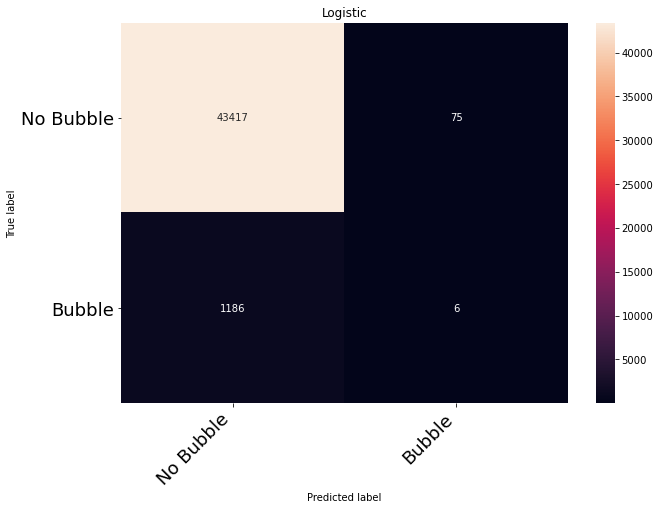

In [31]:
#Start with a simple logistic model to establish a baseline,
X_t = df_impute(X_train)
lm = LogisticRegression()
lm.fit(X_t,y_train)

X_v = df_impute(X_val)
cm = print_confusion_matrix(confusion_matrix(y_val, lm.predict(X_v)), ['No Bubble', 'Bubble'])
plt.title('Logistic')
cm.savefig('figures/reg-logisitic.png')

In [32]:
accuracy_score(y_val, lm.predict(X_v))

0.971779607913347

In [33]:
roc_auc_score(y_val, lm.predict(X_v))

0.5016545509873913

In [34]:
f1_score(y_val, lm.predict(X_v))

0.009426551453260016

In [40]:
#Use ADASYN Oversampling to account for the highly imbalanced dataset
X_adasyn,y_adasyn = ADASYN(random_state=42).fit_sample(X_t,y_train)

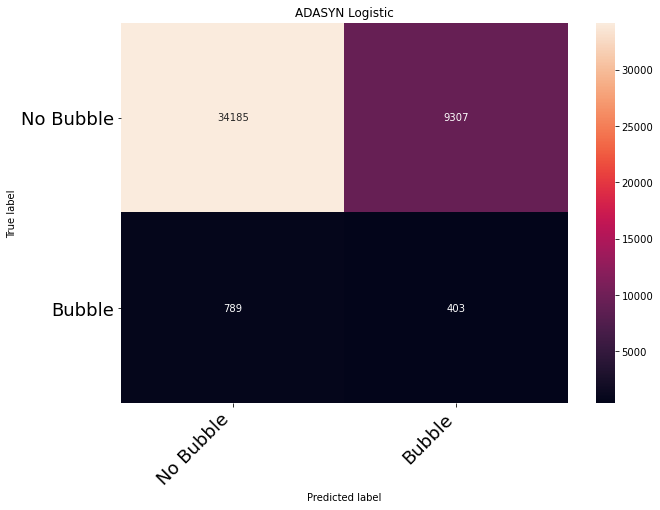

In [41]:
#Logisitic
lm2 = LogisticRegression()
lm2.fit(X_adasyn,y_adasyn)

y_pred = lm2.predict(X_v)

cm = print_confusion_matrix(confusion_matrix(y_val, y_pred), ['No Bubble', 'Bubble'])
plt.title('ADASYN Logistic')
cm.savefig('figures/smote-logisitic.png')

In [42]:
accuracy_score(y_val, y_pred)

0.7740578283054337

In [43]:
roc_auc_score(y_val, y_pred)

0.5620469351148124

In [44]:
f1_score(y_val, y_pred)

0.07393138873601174

In [45]:
#Naive Bayes
nb = GaussianNB()
nb.fit(X_adasyn,y_adasyn)

y_pred = nb.predict(X_v)
roc_auc_score(y_val, y_pred)

0.5076546515998931

In [46]:
accuracy_score(y_val, y_pred)

0.09081550443111629

In [47]:
f1_score(y_val, y_pred)

0.052697850114256393

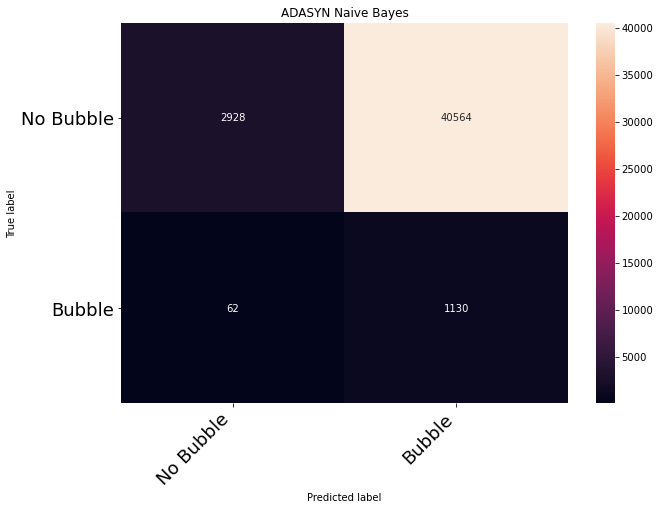

In [48]:
cm = print_confusion_matrix(confusion_matrix(y_val, y_pred), ['No Bubble', 'Bubble'])
plt.title('ADASYN Naive Bayes')
cm.savefig('figures/smote-nb.png')

In [60]:
#SVC
scaler = StandardScaler()
X_ada_scale = scaler.fit_transform(X_adasyn)

model_svc = LinearSVC().fit(X_ada_scale, y_adasyn)

/Users/colinsalama/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


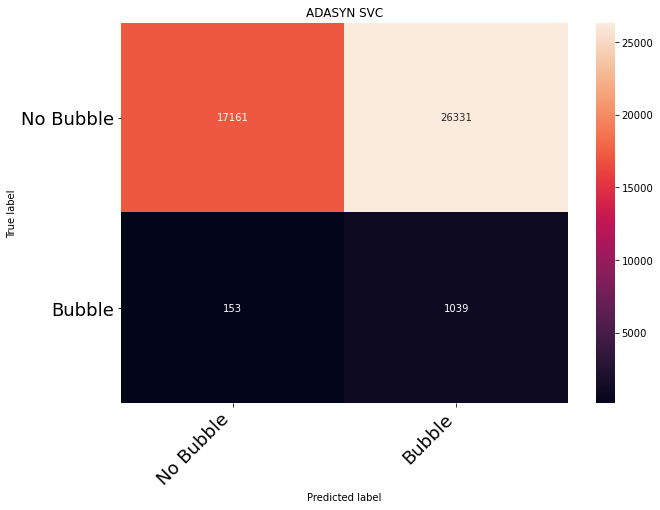

In [61]:
cm = print_confusion_matrix(confusion_matrix(y_val, y_pred), ['No Bubble', 'Bubble'])
plt.title('ADASYN SVC')
cm.savefig('figures/smote-svc.png')

In [55]:
y_pred = model_svc.predict(scaler.fit_transform(X_v))
roc_auc_score(y_val, y_pred)

0.6331113042775127

In [56]:
accuracy_score(y_val, y_pred)

0.40730462805478473

In [57]:
f1_score(y_val, y_pred)

0.07275400882291157

In [62]:
fbeta_score(y_val, y_pred,beta=.5)

0.046940508891137774

In [97]:
#KNN
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_ada_scale, y_adasyn)


0.624788976079532

In [140]:
y_pred = neigh.predict(scaler.fit_transform(X_v))
roc_auc_score(y_val, y_pred)

0.624788976079532

In [141]:
accuracy_score(y_val, y_pred)

0.5443783009578372

In [142]:
f1_score(y_val, y_pred)

0.07673121400390004

In [143]:
fbeta_score(y_val, y_pred,beta=.5)

/Users/colinsalama/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


0.049983457011863686

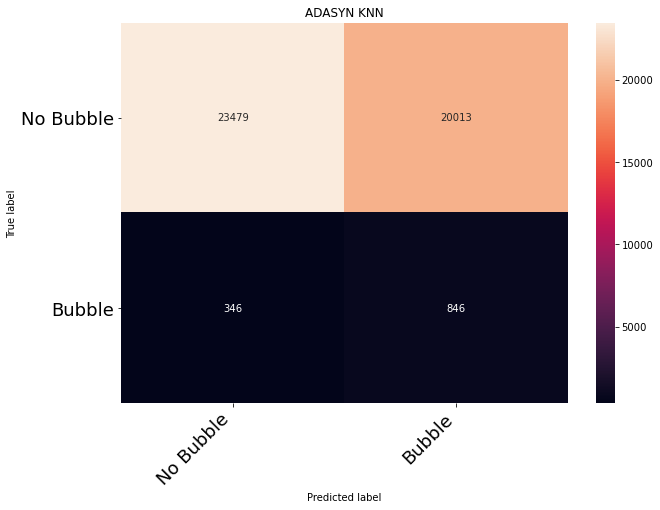

In [100]:
cm = print_confusion_matrix(confusion_matrix(y_val, y_pred), ['No Bubble', 'Bubble'])
plt.title('ADASYN KNN')
cm.savefig('figures/smote-knn.png')

In [130]:
#Try Random Forest
rf = RandomForestClassifier(n_estimators = 100, max_features = 3, n_jobs=-1)
rf.fit(X_adasyn,y_adasyn)


0.6189253273146894

In [161]:

y_pred = rf.predict(X_v)
roc_auc_score(y_val,y_pred )

0.6189253273146894

In [162]:
accuracy_score(y_val,y_pred)

0.9149583743621879

In [163]:
f1_score(y_val,y_pred)

0.16114790286975716

In [164]:
fbeta_score(y_val, y_pred,beta=.5)

/Users/colinsalama/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


0.12548129812981298

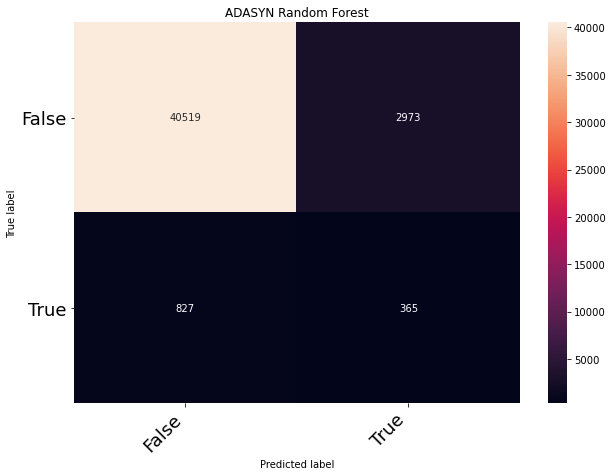

In [165]:
cm = print_confusion_matrix(confusion_matrix(y_val,y_pred), ['False', 'True'])
plt.title('ADASYN Random Forest')
cm.savefig('figures/smote-random-forest.png')

In [105]:
#Implement XGBoost
#Create validation set of 25% size:
X_bt,X_bv,y_bt, y_bv = train_test_split(X_adasyn,y_adasyn,test_size=0.25,random_state=43)

gbm = xgb.XGBClassifier( 
        n_estimators=5000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.05, 
        subsample=.8,
        min_child_weight=3,
        colsample_bytree=.8)
eval_set = [ (X_bt,y_bt),(X_bv,y_bv) ]
fit_model = gbm.fit(X_bt,y_bt,eval_set=eval_set,
                eval_metric='logloss', #new evaluation metric: classification error (could also use AUC, e.g.)
                early_stopping_rounds=50,
                verbose=False)



0.6671751944506341

In [166]:
y_pred = gbm.predict(X_v,ntree_limit=gbm.best_ntree_limit)
roc_auc_score(y_val, y_pred)

0.6671751944506341

In [167]:
accuracy_score(y_val, y_pred)

0.8294020230955151

In [168]:
f1_score(y_val, y_pred)

0.13424190800681435

In [169]:
fbeta_score(y_val, y_pred,beta=.5)

/Users/colinsalama/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


0.09338263177853623

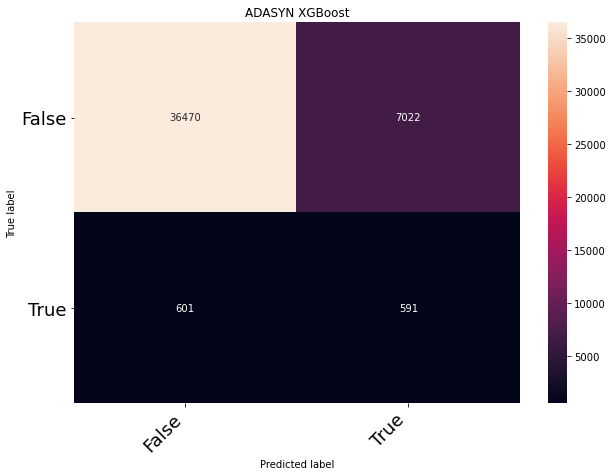

In [170]:
cm = print_confusion_matrix(confusion_matrix(y_val, y_pred), ['False', 'True'])
plt.title('ADASYN XGBoost')
cm.savefig('figures/smote-xgb.png')

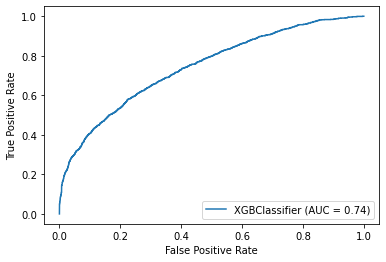

In [171]:
#ROC Curve
plot_roc_curve(gbm,X_v, y_val)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

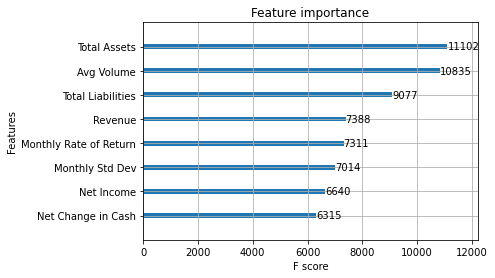

In [110]:
xgb.plot_importance(gbm)

In [111]:
#Using XGBoost on test data:
y_pred = gbm.predict(X_v,ntree_limit=gbm.best_ntree_limit)


## Final Model w Validation Data

In [172]:
X_train = analysis_train.drop(['Crash Next Period','Ticker','Year-Month'],axis=1)
y_train = analysis_train['Crash Next Period']

X_test = analysis_test.drop(['Crash Next Period','Ticker','Year-Month'],axis=1)
y_test = analysis_test['Crash Next Period']

X_t = df_impute(X_train)

#Bootstrap
X_adasyn,y_adasyn = ADASYN(random_state=44).fit_sample(X_t,y_train)

In [173]:
rf = RandomForestClassifier(n_estimators = 100, max_features = 3, n_jobs=-1)
rf.fit(X_adasyn,y_adasyn)

RandomForestClassifier(max_features=3, n_jobs=-1)

In [176]:
y_pred = rf.predict(df_impute(X_test))
roc_auc_score(y_test,y_pred )

0.6310724812014118

In [179]:
fbeta_score(y_test,y_pred,beta=.5)

/Users/colinsalama/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


0.1468604825415855

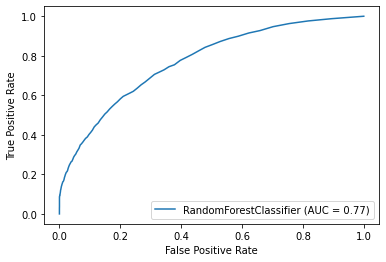

In [185]:
roc_plt = plot_roc_curve(rf,df_impute(X_test), y_test)
plt.savefig('figures/random-forest-roc')

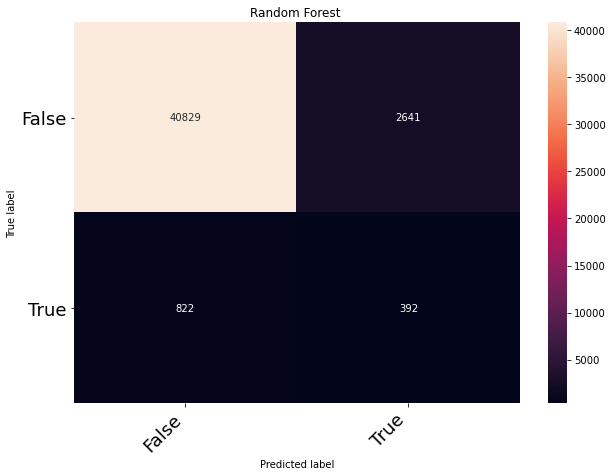

In [178]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), ['False', 'True'])
plt.title('Random Forest ')
cm.savefig('figures/random-forest-final.png')

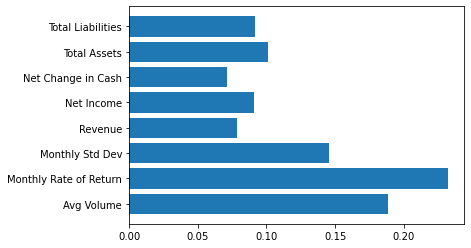

In [188]:
plt.barh(X_train.columns, rf.feature_importances_)
plt.savefig('figures/feature-importance')

### Future Work

In [63]:
# Alternate, more rigorous bubble test.  To be improved in the future.


"""def bubble_check(stock_df,test_threshold = 0.025):

    X = stock_df[['Mkt-RF','Year-Month']]
    X = sm.add_constant(X)
    y = stock_df[['Monthly Rate of Return','Year-Month']]


    #t = X.loc[:,'Year-Month'].iloc[-1]
    #possible_break_periods = pd.date_range(start='1/1/2020',end=''  )   

    possible_break_periods = X.loc[:,'Year-Month'].iloc[-60:-12]
    if len(possible_break_periods.values) == 0:
        return False
    #Check to make sure these periods aren't empty, and return if it is.

    t_values = []
    p_values = []

    #The following should range between 12 months ago and 60 months ago from the current period t.  Consider also varying t
    for break_period in possible_break_periods: 

        X['break_period'] = break_period
        X['struct_change'] = 0
        X.loc[ X['Year-Month'] > X['break_period'], 'struct_change'] = 1
        X_te = X.drop(['break_period','Year-Month'],axis=1)
        y_te = y.drop('Year-Month',axis=1)

        model = sm.OLS(y_te,X_te,missing='drop')
        results = model.fit()
        r = np.zeros_like(results.params)
        r[2] = 1
        #Now add the t value and the p value of struct change to lists.
        #Then we need to maximize the t value for all of the possible dates we have.
        T_test = results.t_test(r)
        t_values.append(abs(T_test.tvalue))
        p_values.append(T_test.pvalue)

    i = t_values.index(max(t_values))
    if p_values[i] < test_threshold:
        start_date = possible_break_periods.iloc[i]
        X.loc[:,'break_period'] = start_date
        y.loc[:,'break_period'] = start_date
        X_struct_test = X.loc[ X['Year-Month']>X['break_period'],:].drop(['Year-Month','break_period','struct_change'],axis=1)
        y_struct_test = y.loc[ y['Year-Month']>y['break_period'],:].drop(['Year-Month','break_period'],axis=1)

        model = sm.OLS(y_struct_test,X_struct_test,missing='drop')
        results = model.fit()
        #Check if the alpha_2 is significant
        r = np.zeros_like(results.params)
        r[0] = 1
        T_test = results.t_test(r)
        if T_test.pvalue < test_threshold:
            #might be useful to return a full dataframe of all of the relevant information
            #return pd.DataFrame([],columns=['']) 
            return True
    return False


    #If t test passes significance level, there is a bubble from the start_date to current time period.

    #the t value on struct_change, and if that is under some test value, run a regression for just all values with struct_change = 1
    # and save 
    
all_tickers = regression_df['Ticker'].unique()
bubble_bool = []

for ticker in all_tickers:
    temporary_stock = regression_df.loc[regression_df['Ticker'] == ticker]
    bubble_bool.append(bubble_check(temporary_stock))
    
    
main_cat = pd.DataFrame({'Ticker':list(all_tickers),'Bubble':bubble_bool})

#Save this data to a CSV
main_cat.to_csv('raw_data/raw_bubble_data.csv',index=False)

#Take a look at all of the positive bubble indicators
main_cat.loc[main_cat['Bubble']==True,:]
    
"""

"def bubble_check(stock_df,test_threshold = 0.025):\n\n    X = stock_df[['Mkt-RF','Year-Month']]\n    X = sm.add_constant(X)\n    y = stock_df[['Monthly Rate of Return','Year-Month']]\n\n\n    #t = X.loc[:,'Year-Month'].iloc[-1]\n    #possible_break_periods = pd.date_range(start='1/1/2020',end=''  )   \n\n    possible_break_periods = X.loc[:,'Year-Month'].iloc[-60:-12]\n    if len(possible_break_periods.values) == 0:\n        return False\n    #Check to make sure these periods aren't empty, and return if it is.\n\n    t_values = []\n    p_values = []\n\n    #The following should range between 12 months ago and 60 months ago from the current period t.  Consider also varying t\n    for break_period in possible_break_periods: \n\n        X['break_period'] = break_period\n        X['struct_change'] = 0\n        X.loc[ X['Year-Month'] > X['break_period'], 'struct_change'] = 1\n        X_te = X.drop(['break_period','Year-Month'],axis=1)\n        y_te = y.drop('Year-Month',axis=1)\n\n        